# Installer Numpy avec OpenBlas

Si vous vous contentez d'installer *Numpy* avec la commande *pip* seule ou les librairies système de votre distribution Linux préférée vous risquez d'obtenir une librairie 100% opérationnelle mais ayant de très mauvaises performances.

![Librairie numpy système versus numpy + openblas](openblas_vs_system.png)

Pour être efficace il convient de [l'installer en l'accompagnant de librairies mathématiques vectorisées](https://www.scipy.org/scipylib/building/index.html), parmi :

* [Atlas](http://math-atlas.sourceforge.net/), [Blas](http://www.netlib.org/blas/), [Lapack](http://www.netlib.org/lapack/)
* [OpenBlas](http://www.openblas.net/)
* Intel [MKL](https://software.intel.com/en-us/intel-mkl)
* AMD [ACML](http://developer.amd.com/tools-and-sdks/archive/compute/amd-core-math-library-acml/)
* ...

Le couple ATLAS+Lapack est une excellente solution, malheureusement depuis que j'ai changé de PC je n'arrive plus à le compiler correctement.

Aussi je vous propose de découvrir comment installer votre librairie numpy avec la librairie *OpenBlas* fraichement compilée pour votre système.

## Installer les outils de développement

```bash
bash> sudo apt-get install build-essential
bash> sudo apt-get install gfortran
```

## Télécharger OpenBlas

```bash
bash> git clone https://github.com/xianyi/OpenBLAS.git`
cd OpenBlas
```

Ou

```bash
bash> wget http://github.com/xianyi/OpenBLAS/archive/v0.2.20.tar.gz
bash> tar xzf v0.2.20.tar.gz
bash> cd OpenBLAS-0.2.20
```

## Compiler
`bash> make`

## Installer
`bash> make install PREFIX=<your path> # Exemple : /opt/openblas ou /usr/local`



## Installer numpy avec OpenBlas
Une fois la librairie installée, il convient d'installer une version de numpy en lui indiquant au préalable comment la trouver

```bash
bash> virtualenv -p /usr/bin/python3 openblas
bash> cd openblas
bash> source bin/activate
```

Avant d'installer numpy dans l'environnement virtuel assurez-vous qu'il puisse trouver les binaires et entêtes de la librairie:

```bash
bash> export LD_LIBRARY_PATH=/opt/openblas/lib:$LD_LIBRARY_PATH
```

Pour les entêtes sous */usr/local* normalement cela fonctionne bien. Si vous ne vous rappelez pas comme moi de la variable d'environnement à définir pour que gcc les trouve, vous pouvez aussi les copier de */opt/openblas/include* vers le dossier *include* du virtualenv de Python.

Ce n'est pas bien, mais pour la démo cela fonctionnera très bien.

Vous pouvez maintenant installer numpy avec *pip*

```
(python35)bash> pip install numpy
```

Puis testez la configuration:

```python
Python 3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> import numpy as np
>>> np.__config__.show()
openblas_info:
    define_macros = [('HAVE_CBLAS', None)]
    libraries = ['openblas', 'openblas']

```

## Et maintenant testons avec un numpy système

La librairie numpy installée avec Python 3 de ma distribution Linux Mint n'offre aucune librairie vectorisée.

In [1]:
!/usr/bin/python3 -c "import numpy as np; np.__config__.show()"

lapack_opt_info:
    library_dirs = ['/usr/lib']
    define_macros = [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)]
    libraries = ['lapack', 'lapack', 'blas', 'blas']
    language = c
openblas_lapack_info:
  NOT AVAILABLE
atlas_3_10_info:
  NOT AVAILABLE
atlas_3_10_threads_info:
  NOT AVAILABLE
openblas_info:
  NOT AVAILABLE
atlas_3_10_blas_threads_info:
  NOT AVAILABLE
blas_info:
    library_dirs = ['/usr/lib']
    define_macros = [('HAVE_CBLAS', None)]
    libraries = ['blas', 'blas']
    language = c
atlas_blas_info:
  NOT AVAILABLE
lapack_mkl_info:
  NOT AVAILABLE
atlas_3_10_blas_info:
  NOT AVAILABLE
lapack_info:
    library_dirs = ['/usr/lib']
    libraries = ['lapack', 'lapack']
    language = f77
blas_opt_info:
    library_dirs = ['/usr/lib']
    define_macros = [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)]
    libraries = ['blas', 'blas']
    language = c
blas_mkl_info:
  NOT AVAILABLE
mkl_info:
  NOT AVAILABLE
atlas_info:
  NOT AVAILABLE
atlas_blas_threads_info:
  NOT AVAILABL

In [2]:
!/opt/openblas/p35/bin/python -c "import numpy as np; np.__config__.show()"

blas_opt_info:
    libraries = ['openblas', 'openblas']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
    library_dirs = ['/usr/local/lib']
openblas_info:
    libraries = ['openblas', 'openblas']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
    library_dirs = ['/usr/local/lib']
lapack_mkl_info:
  NOT AVAILABLE
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
    library_dirs = ['/usr/local/lib']
blis_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
    library_dirs = ['/usr/local/lib']
blas_mkl_info:
  NOT AVAILABLE


Mesurons maintenant le temps d'exécution de ces 2 versions de numpy (système et openblas)

In [3]:
%%file benchmark.py 
# coding=utf8
import sys
import numpy as np
import time

n = 100

times = []

while n <= 2000:
    mat = np.random.rand(n,n)
    
    # Compute dot product (do a lot of additions and multiplications)
    start = time.time()
    r = np.dot(mat, mat) # mat @ mat
    end = time.time()
    
    compute_time = end - start
    times.append((n, compute_time))
    print(n, compute_time)
    n += 200
    
# Save it to a file
np.save(sys.argv[1], times)

Overwriting benchmark.py


Calcul des performances avec le python système

In [4]:
!/usr/bin/python3 benchmark.py "system.npy"


100 0.0005905628204345703
300 0.015039205551147461
500 0.0718848705291748
700 0.19284796714782715
900 0.4713737964630127
1100 1.0199275016784668
1300 1.661370038986206
1500 2.5973589420318604
1700 4.0269129276275635
1900 5.499075651168823


Calcul des performances avec le python openblas

In [5]:
!OPENBLAS_NUM_THREADS=4 /opt/openblas/p35/bin/python benchmark.py "openblas.npy"

100 0.013395071029663086
300 0.0008711814880371094
500 0.00302886962890625
700 0.010390043258666992
900 0.01829385757446289
1100 0.03714323043823242
1300 0.05067086219787598
1500 0.07104825973510742
1700 0.09233474731445312
1900 0.13447022438049316


Traçons le graphique de comparaison

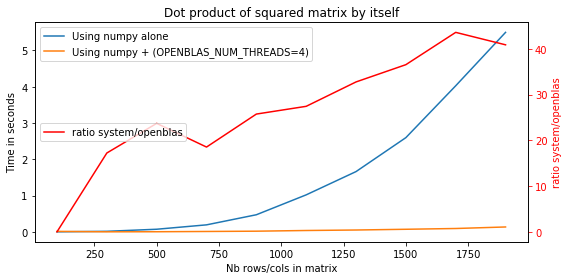

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

s = np.load("system.npy")
o = np.load("openblas.npy")

fig, ax1 = plt.subplots(figsize=(8,4))


ax1.plot(s[:, 0], s[:, 1], label="Using numpy alone")
ax1.plot(o[:, 0], o[:, 1], label="Using numpy + (OPENBLAS_NUM_THREADS=4)")
ax1.set_ylabel("Time in seconds")
ax1.legend()

ax2 = ax1.twinx()
ax2.set_ylabel('ratio system/openblas', color='r')
ax2.plot(s[:, 0], s[:, 1]/o[:, 1], c='red'
         , label="ratio system/openblas")
ax2.tick_params('y', colors='r')
ax2.legend(loc='center left')


plt.title("Dot product of squared matrix by itself")
ax1.set_xlabel("Nb rows/cols in matrix")
fig.tight_layout()
plt.savefig('openblas_vs_system.png')
plt.show();